In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from kaggle_datasets import KaggleDatasets
# !pip install tensorflow==2.13
import tensorflow as tf
from tensorflow import keras
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import Input, Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, ZeroPadding2D, ReLU, LeakyReLU, Dropout, GroupNormalization, Concatenate
from keras.layers import Lambda, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast, RandomTranslation, RandomCrop

2024-02-14 02:20:35.897740: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 02:20:35.897841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 02:20:36.035803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# INTRODUCTION & SETUP
This notebook trains a CycleGAN to transfer a Monte styling to real photos. CycleGANs are a type of adversarial network commonly used in style transfer. In this implementation, a generator network learns to create fake monet images from real photos, while a discriminator network learns to distinguish real and phake monet images. With training, each network pushes the other to improve.

On a personal note, I learned a ton from this competition. Along the way, I've written comments to help myself and my future self better understand CycleGANs, the TensorFlow and Keras APIs, and a few object-oriented programming concepts. 

### TENSORFLOW CONFIGURATION (TPU, GPU, OR CPU)

The code below sets the model training strategy according to the processor type, and outputs the processor details.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    tf.config.experimental_connect_to_cluster(tpu) # Connects to the given cluster
    tf.tpu.experimental.initialize_tpu_system(tpu) # Initializes the TPU system
    strategy = tf.distribute.TPUStrategy(tpu) # TPU distribution strategy
    print('Running on TPUs')

except ValueError:
    print("TPU not available.")
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print("Running on GPU.")
    else:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU.")

print('Number of accelerators (CPU, GPU, or TPU):', strategy.num_replicas_in_sync)

print("Tensor Flow Version:", tf.__version__)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

TPU not available.
Running on GPU.
Number of accelerators (CPU, GPU, or TPU): 1
Tensor Flow Version: 2.15.0
Your runtime has 33.7 gigabytes of available RAM

You are using a high-RAM runtime!


# LOAD, PARSE, AND PREPROCESS DATA
We will use the TensorFlow's TFRecord files (`.tfrec`) provided by Kaggle. `.tfrec` files are binary, record-oriented files that integrate with TensorFlow's ecosystem and are optimimzed for fast read and write times.

### LOAD AND PARSE FUNCTIONS

In [3]:
# parse_tfrecord converts the serialized TFRecord into a 3-D tensor, 256x256x3
def parse_tfrecord_fn(example):
  # `feature_description` specifies the structure of data stored in the TFRecord file
  # tf.string is a Tensor data type that can hold byte strings, like binary, jpeg-encoded images
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }

    # convert serialized tfrecords into Tensor Flow 'dict', {'image': tf.string}.
    example = tf.io.parse_single_example(example, feature_description)

    # decode the tf.string into a 3-D tensor with dtype `tf.uint8`
    image = tf.io.decode_jpeg(example['image'], channels=3)

    # Set datatype to float32 before normalizing
    image = tf.cast(image, tf.float32)

    # Normalizing to [-1, 1] is standard practice and speeds up training.
    image = (image / 127.5) - 1

    # Resize for GAN input 256x256
    image = tf.image.resize(image, [256, 256])
    return image

# Define a function to extract images from the TFRecord files
def load_dataset(filenames):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
    return parsed_dataset

### LOAD MONET AND PHOTOS DATASETS

In [4]:
"""
Code Notes:
io  -->  "Input/Output", provides the interface between the program and the operating system
gfile  --> "Generic File", provides an API that is close to Python's file object, but based on TensorFlow's C++ FileSystem API
glob --> finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
"""
GCS_PATH = KaggleDatasets().get_gcs_path()

monet_filenames = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))
photos_filenames = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print("Photos TFRecord Files:", len(photos_filenames))

monet_dataset = load_dataset(monet_filenames)
photos_dataset = load_dataset(photos_filenames)
photo_originals = load_dataset(photos_filenames)

Monet TFRecord Files: 5
Photos TFRecord Files: 20


### DATA AUGMENTATION

My first training attempts transferred convincing monet-like styling to photos, but the generated images had clear artifacts. Faint gridlines and other subtle abnormalities were added to most photos. Large monochromatic areas like skies and bodies of water had a tendancy to pick up chattery patterns that humans would cleary recognize as "not-Monet". In an attempt to reduce these artifacts and improve the model fit, I augmented both datasets by jittering images (enlarge and randomly crop), randomly flipping and rotating images, and randomly tweaking the contrast and brightness. These approaches should help with general model training becuase they effectively increase the size of both datasets, and the monet dataset is otherwise small at 300 images. These methods seemed to reduce the artifacts, but did not eliminate them. 

In [5]:
# Random Jitter
def resize(image, height, width):
    image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

@tf.function()
def RandomJitter(image):
    image = resize(image, 286, 286)
    image = random_crop(image) # back to 256 x 256 x 3
    image = tf.image.random_flip_left_right(image)

    return image

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(factor=0.2), # '.2' means .2 * pie = 36 degrees
    RandomZoom(height_factor=0.2),
    RandomBrightness(factor=0.2, value_range=[0.0, 1.0]),
    RandomContrast(factor=0.2),
    Lambda(RandomJitter)
])

def apply_augmentation(image):
  image = data_augmentation(image, training=True)
  return image

AUTOTUNE = tf.data.AUTOTUNE # For dataset configuration

monet_dataset = monet_dataset.map(apply_augmentation, num_parallel_calls = AUTOTUNE)
photos_dataset = photos_dataset.map(apply_augmentation, num_parallel_calls = AUTOTUNE)

### BATCH AND BUFFER THE DATASETS
Normally, I would use a batch size based on a power of 2 for computational efficiency. Batch sizes of 32, 64, 128, and 256 are fairly standard. However, for tasks involving fine-grained updates, small batches allow for more frequent updates and can help convergence. Batch sizes as small as 1 can help the CycleGAN learn mappings between individual images from the two domains. 

Also, our CycleGAN model architecture requires the monet and photo batches to be the same size. With 300 and 7028 elements in the monet and photos datasets, batch size of 1, 2, and 4 would ensure equal batch sizes in both datasets and avoid dropped remainders. Other CycleGANs have succesfully used a batch size of 1, so we'll use the same.

A buffer size of 1024 should be large enough to ensure good randomization of image order from one epoch to the next, and minimize slowdowns.

### TESTING AND TROUBLESHOOTING CODE (Uncomment as needed)
While troubleshooting, I found it helpful to reduce the dataset sizes to 10 each. This temporary measures allowed me to itterate through changes without waiting a long time to see the output or discover an error.

In [6]:
# photos_dataset = photos_dataset.take(10)
# monet_dataset = monet_dataset.take(10)

In [7]:
# Batch and shuffle the dataset
BUFFER_SIZE = 1024
BATCH_SIZE = 1

monet_dataset = monet_dataset.batch(BATCH_SIZE, drop_remainder=True).shuffle(BUFFER_SIZE)
photos_dataset = photos_dataset.batch(BATCH_SIZE, drop_remainder=True).shuffle(BUFFER_SIZE)
photo_originals = photo_originals.batch(BATCH_SIZE, drop_remainder=True).shuffle(BUFFER_SIZE)

# Apply prefetching with AUTOTUNE at the end of the pipeline
monet_dataset = monet_dataset.prefetch(AUTOTUNE)
photos_dataset = photos_dataset.prefetch(AUTOTUNE)

### SAMPLE MONET AND PHOTO

TensorFlow operates in eager execution mode, which means operations return concerete values instead of computational graphs. This means TensorFlow tensors can be direclty accessed and manipulated by other APIs, like NumPy and Matplotlib, as demonstrated by the plots below.

Monet and Photo data type: <class 'tensorflow.python.framework.ops.EagerTensor'>


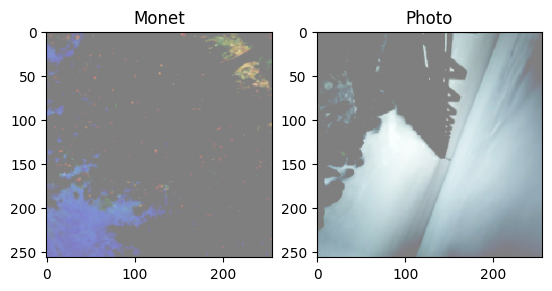

In [8]:
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photos_dataset))

print(f'Monet and Photo data type: {type(example_monet)}')

plt.subplot(121)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5);

plt.subplot(122)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5);

# DESIGN CYCLEGAN

My strategy is to use a UNET architecture to build a generator and discriminator. UNET architecture is utilized in the TensorFlow guides for [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) and [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix) and is described in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/)

A small difference between my model and those in the aforementioned TensorFlow guides is that we use instance normalization instead of batch normalization. Instance normalization performs normalization for each specific instance (image or photo) independently. It computes the mean and variance for each channel in each training example. Instance normalization is often used in style transfer models, where the style of individual images can matter more than the average style of a batch of images.

Unfotunately, Keras does not have a built-in instance normalization layer. While `tfa.layers.InstanceNormalization` is available from the TensorFlow Addons library, the module is no longer maintained. To future proof the code, I will use GroupNormalization and set the group size equal to the number of input channels. With this setting, GroupNormalization is effectively instance normalization, as each channel of each image will be normalized to a mean of 0 and standard deviation of 1.

Building the CycleGAN generator will involve multiple downsample blocks to encode basic features and multiple upsample blocks to generate the output. To simplify the code, I create downsample and upsample funtions that combine standard layers (Conv2D/Conv2DTranspose, GroupNormalization, Dropout, and LeakyReLu/Relu) into blocks. The blocks are shorter and easier to work with, and still allow specification of filter number and kernel size. This technique is demonstrated in the [Pix2Pixtutorial](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fwww.tensorflow.org%2Ftutorials%2Fgenerative%2Fpix2pix) and by Amy Jang in her [tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial).

### DOWNSAMPLE FUNCTION

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, kernel_size=4, strides=2, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = Sequential()
    result.add(Conv2D(filters,
                      kernel_size,
                      strides=strides,
                      padding='same',
                      kernel_initializer=initializer,
                      use_bias=False))

    if apply_instancenorm:
        result.add(GroupNormalization(gamma_initializer=gamma_init,
                                      groups=filters))

    result.add(LeakyReLU())

    return result

### UPSAMPLE FUNCTION

In [10]:
def upsample(filters, kernel_size=4, strides=2, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(Conv2DTranspose(filters,
                               kernel_size,
                               strides=strides,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(GroupNormalization(gamma_initializer=gamma_init,
                                  groups=filters))

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

### GENERATOR FUNCTION
In the generator function, each downsample and upsample block is composed of a convolutional layer, a group normalization layer, a dropout layer, and a ReLU or LeakyReLU activation function. The final layer is a convolutional layer with a tanh activation function.

The generator function uses **skip connections** to concatenate identically shaped outputs from the downsample and upsample blocks. Essentially, they "skip" layers to concatenate input and output layers.

Skip connections help to preserve the original image information and reduce the vanishing gradient problem. These are critical features of image-to-image translations, because they preserve detailed information across the network.

In [11]:
def Generator():
    inputs = Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(filters=64,
                   apply_instancenorm=False),   # output dim = (bs, 128, 128, 64)
        downsample(128), # output dim = (bs, 64, 64, 128)
        downsample(256), # output dim = (bs, 32, 32, 256)
        downsample(512), # output dim = (bs, 16, 16, 512)
        downsample(512), # output dim = (bs, 8, 8, 512)
        downsample(512), # output dim = (bs, 4, 4, 512)
        downsample(512), # output dim = (bs, 2, 2, 512)
        downsample(512), # output dim = (bs, 1, 1, 512)
    ]
    
    # The output of each upsample layer is double the number of filters, because
    # the skip connections concatenate the output of the downsample layer to  
    # a corresponding upsample layer
    
    up_stack = [
        upsample(filters=512,
                 apply_dropout=True), # concat'd output dim = (bs, 2, 2, 1024)
        upsample(512, apply_dropout=True), # concat'd output dim = (bs, 4, 4, 1024)
        upsample(512, apply_dropout=True), # concat'd output dim = (bs, 8, 8, 1024)
        upsample(512), # concat'd output dim = (bs, 16, 16, 1024)
        upsample(256), # concat'd output dim = (bs, 32, 32, 512)
        upsample(128), # concat'd output dim = (bs, 64, 64, 256)
        upsample(64), # concat'd output dim = (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(OUTPUT_CHANNELS,
                           kernel_size = 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and creating skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### DISCRIMINATOR
In the discriminator function, each downsample block is composed of a convolutional layer, a group normalization layer, a dropout layer, and a LeakyReLU activation function.

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(filters=64,
                       apply_instancenorm=False)(x)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)

    zero_pad1 = ZeroPadding2D()(down3)

    conv = Conv2D(filters=512,
                         kernel_size=4,
                         strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = GroupNormalization(gamma_initializer=gamma_init,
                               groups=512)(conv)

    leaky_relu = LeakyReLU()(norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    last = Conv2D(filters=1, kernel_size=4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return Model(inputs=inp, outputs=last)

### APPLY DISTRIBUTION STRATEGY TO MODELS


In [13]:
with strategy.scope():
    monet_generator = Generator()
    photo_generator = Generator()

    monet_discriminator = Discriminator()
    photo_discriminator = Discriminator()

### PHOTO AND MONET-LIKE FROM UNTRAINED GENERATOR

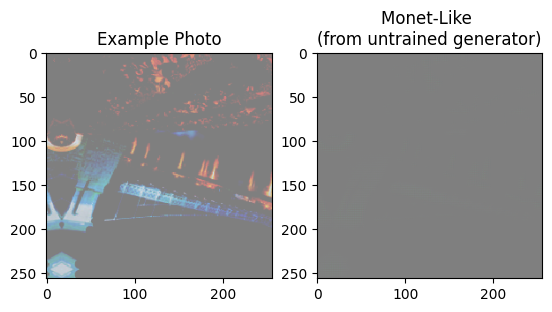

In [14]:

example_photo = next(iter(photos_dataset))
monet_like = monet_generator(example_photo)

plt.subplot(121)
plt.title("Example Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)


plt.subplot(122)
plt.title("Monet-Like \n(from untrained generator)")
plt.imshow(monet_like[0] * 0.5 + 0.5)



# ARCHITECTURE DIAGRAM & SUMMARY

### GENERATOR ARCHITECTURE

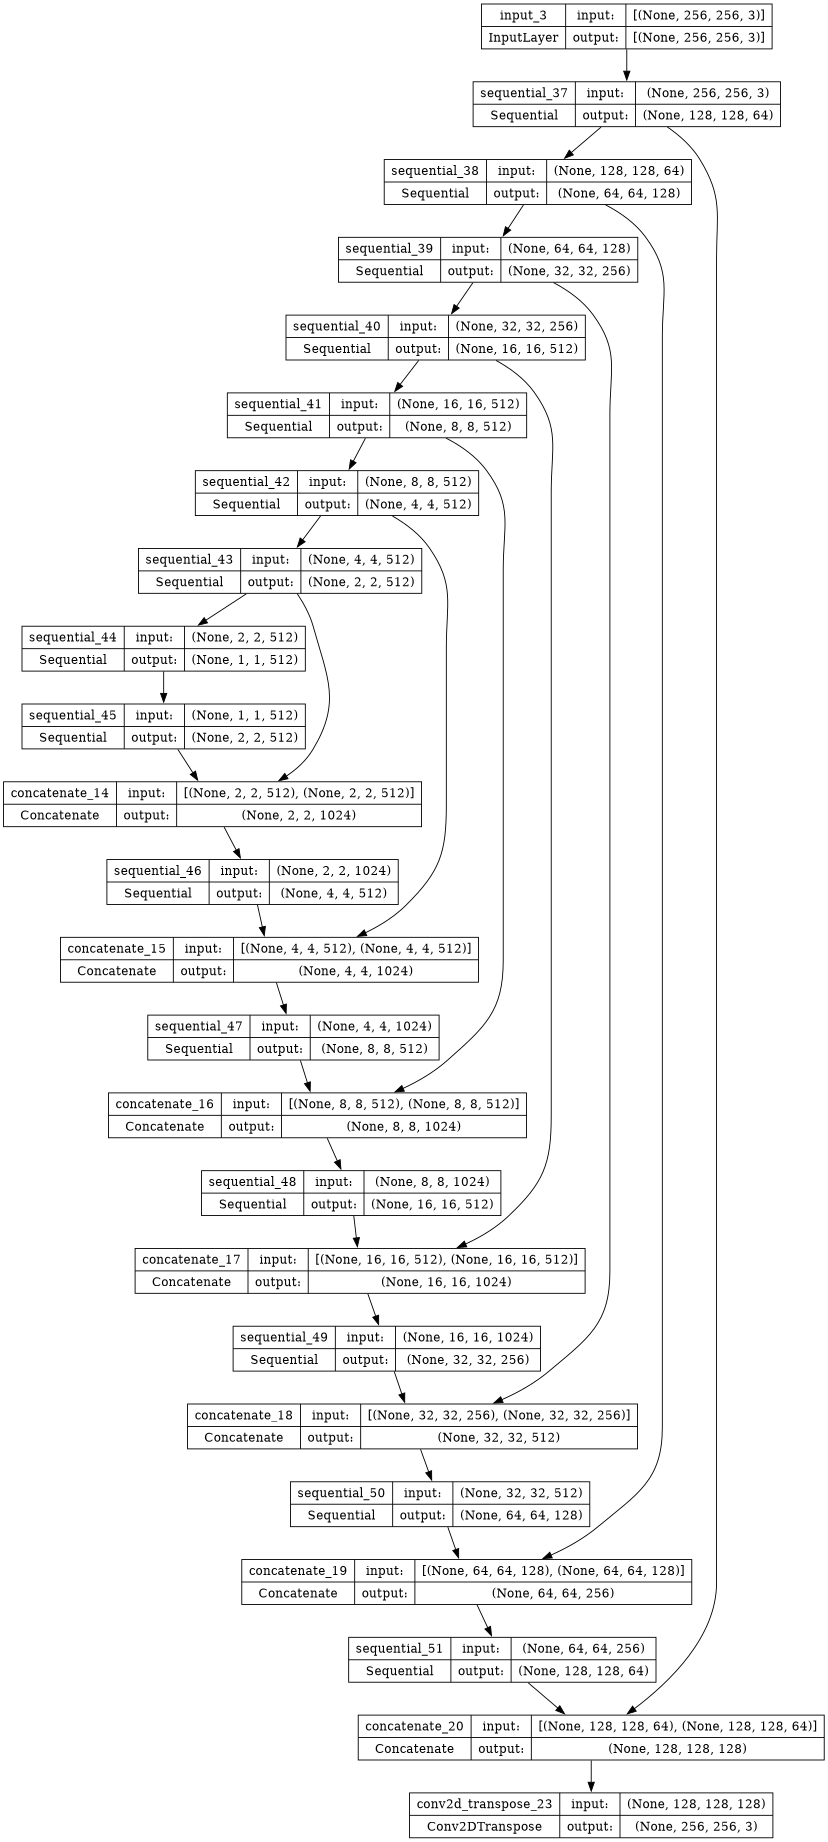

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### GENERATOR SUMMARY

In [16]:
print("Monet Generator Model Summary:", monet_generator.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 64, 64, 128)          131328    ['sequential_1[0][0]']        
                                                                                                  
 sequential_3 (Sequential)   (None, 32, 32, 256)          524800    ['sequential_2[0][0]']        
                                                                                              

### DISCRIMINATOR ARCHITECTURE

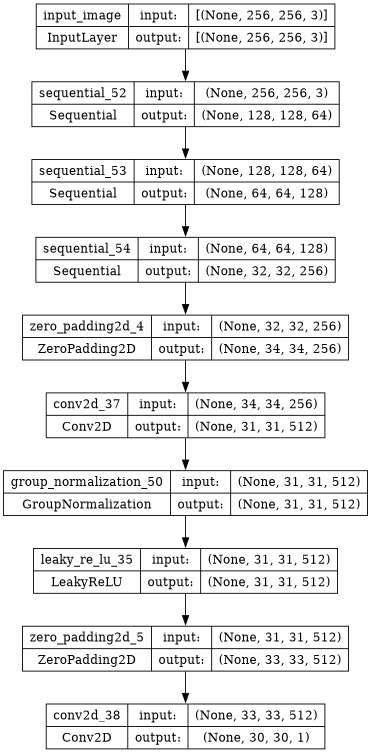

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### DISCRIMINATOR SUMMARY

In [18]:
print("Monet Discriminator Model Summary:", monet_discriminator.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_31 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_32 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_33 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPaddin  (None, 34, 34, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

# CLASS CYCLGAN (MODEL ENCAPSULATION)

Here I define a class "CycleGan", which will construct a TensorFlow model from the generators and discriminator functions defined earlier. Below are important Python and object-oriented-progreamming concepts represented in this code.

1) The CycleGan class **encapsulates** everything related to the CycleGAN model, including the generator and discriminator components and how compilation and training are performed.

2) `class CycleGan(keras.Model)` sets up **inheritance** of methods from keras.Model. Instances of the CycleGan class will have fit(), evaluate(), and predict() methods from Keras, among other methods.

3) The **super()** command is used to call specific methods from the keras.Models superclass. The inheritance described in 2) makes the keras.Model methods available, but the super() command applies those methods in specific functions within the CycleGan class. In this case, the two super() commands ensure that the initialization (__init__) and compilation (compile) logic from the keras.Model superclass are properly integrated into CycleGan.  

4) The 'train_step' method is an example of **polymorphism**, where `train_step` from the keras.Model is overridden by the custom `train_step` code written into this class definition.

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super().__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super().compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # generating a cycled photo: photo --> fake monet --> photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # generating a cycled monet: monet --> fake photo --> monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating same monet and same photo
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminating real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminating fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # generator losses on fake images
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # total generator losses
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # discriminator losses
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))


        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# LOSS FUNCTIONS AND OPTIMIZERS
Loss metrics for CycleGANs. include generator and discriminator losses, cycle consistency loss and identity loss. Cycle consistency loss measures how well an input image is reconstructed after a round trip transformation, e.g. monet --> photo --> monet. Identity loss measures how much an image changes when passesd through the generator of its own domain, e.g. monet --> monet.

`strategy.scope()` tells TensorFlow to distribute the model's operations according to the strategy defined in the "CONFIGURE TENSORFLOW" section near the beginning of this document.

In [20]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        
        return tf.reduce_mean(total_disc_loss) * 0.5 # Reduce to scalar for TensorBoard or plotting loss vs epoch
#         return total_disc_loss * 0.5 # Keep as an array if not using TensorBoard or plotting loss vs epoch

In [21]:
with strategy.scope():
    def generator_loss(generated):
        
        return tf.reduce_mean(BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
                         (tf.ones_like(generated), generated)) # Reduce to scalar for TensorBoard
#         return (BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
#                 (tf.ones_like(generated), generated))# Keep as an array if not using TensorBoard



In [22]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [23]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [24]:
# Use `legacy.Adam` when training on M1 laptop. Use `Adam` when training on Google Colab or Kaggle Notebook
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# INSTANTIATE MODEL

In [25]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

# FIT CYCLGAN

Below, I setup callbacks that save the model weights every 10 epochs. This isn't necessary, but I'd like to see examples of Monet-like images produced by the generator trained to different epochs. I'm hoping the Monet-like images will be noticeably improved across the different epochs, as this would help determine when the model is sufficiently trained. Knowing when the model is appropriately trained is difficult due to the four CycleGAN losses that represent competition between generating and disciminating images. I don't believe that any single loss is sufficiently informative to guide training, and even considering the losses in aggregate may not suffice. My reasoning is that while the Monet generator improves, so should the Monet Discriminator. If the generator and disciminator improve in roughly equal proportions, the losses may change very little or unpredictably. The same should be true for the photo generator and disciminator. However, the generator losses include cycle loss and identity loss, which (theoretically) can be reduced with training, even if the generator and disciminator remain balanced. In short, scrutiny of the losses might, or might not allow us to pinpoint when training should stop.

In [26]:
# Set up checkpoint callback
checkpoint_path = 'checkpoints/'
checkpoint_name = 'cp-{epoch:04d}.ckpt'
filepath = checkpoint_path + checkpoint_name
checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    verbose=0,
    save_weights_only=True,
    save_freq=3000) # Save a checkpoint every 10 epochs (1 epoch = 300 batches)

# If checkpoints exist, load the latest one
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_path)
if latest_checkpoint:
    cycle_gan_model.load_weights(latest_checkpoint)
    print(f"Loaded weights from {latest_checkpoint}")
else:
    print("No checkpoint found. Starting training from scratch.")
    

No checkpoint found. Starting training from scratch.


In [27]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photos_dataset)),
    verbose=0,
    epochs=40,
    callbacks = [checkpoint_callback]
)

2024-02-14 02:22:03.363235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/sequential_11/dropout_2/dropout_2/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707877338.860053      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# MODEL EVALUATION

The line graph below shows dramatic loss oscillations for the Monet and photo generators. From about epochs 10 to 40, the generator losses and disciminator losses seem to move in opposite direction. Presumabely, improvements in disciminator function result in higher generator loss, and vice versa. The ideal number of training epochs is not obvious. While it might be tempting to choose an epoch with the lowest generator loss, a change in generator loss could represent diminished generator performance, or an improvement in discriminator performance. I've submitted notebooks with 25 and 50 training epochs thus far and obtained Kaggle scores (Memorization-Informated Frechet Inception Distance) of 71.9 and 73.0 respectively. Is this difference purely random, or is 50 epochs too many?  Hard to say!

For this last submission, I used `tf.reduce_mean` in the generator and discriminator loss calculations to produce plottable scalar values, as shown below. I don't expect the change to have a large impact on training, but comparing this submission to earlier submissions won't be exactly "apples-to-apples". I will train to 40 epochs before generating the Monet-like images for submission.

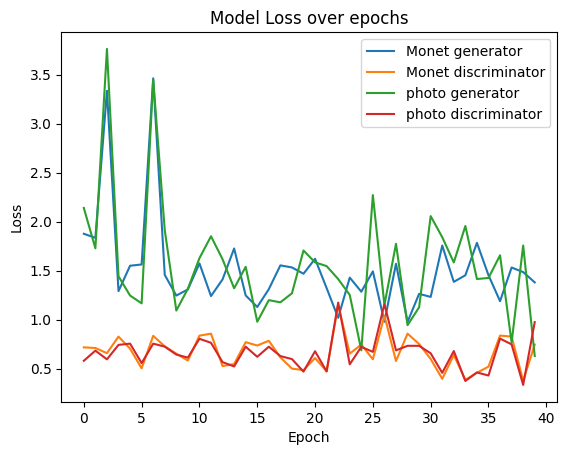

In [28]:
plt.plot(cycle_gan_model.history.history['monet_gen_loss'], label = 'Monet generator')
plt.plot(cycle_gan_model.history.history['monet_disc_loss'], label = 'Monet discriminator')
plt.plot(cycle_gan_model.history.history['photo_gen_loss'], label = 'photo generator')
plt.plot(cycle_gan_model.history.history['photo_disc_loss'], label = 'photo discriminator')
plt.title("Model Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.show()

### MONET-LIKE IMAGES AFTER 10, 20, 30 and 40 TRAINING EPOCH
While Memorization-Informed Frechet Inception Distance (MiFID) is the competition criteria, I'd like to see if noticeable differences exist in the quality of style transfer at different timepoints in training. The plot below shows monet-like generated images from the CycleGAN model trained to 10, 20, 30 and 40 epochs. I believe the color intensity changes slightly over the epochs, but this could be my imagination. Otherwise, I don't observe substantial differences across the epochs. Out of curiosity, I will submit the notebook to Kaggle a few times with images generated from a model trained at differrent epochs.


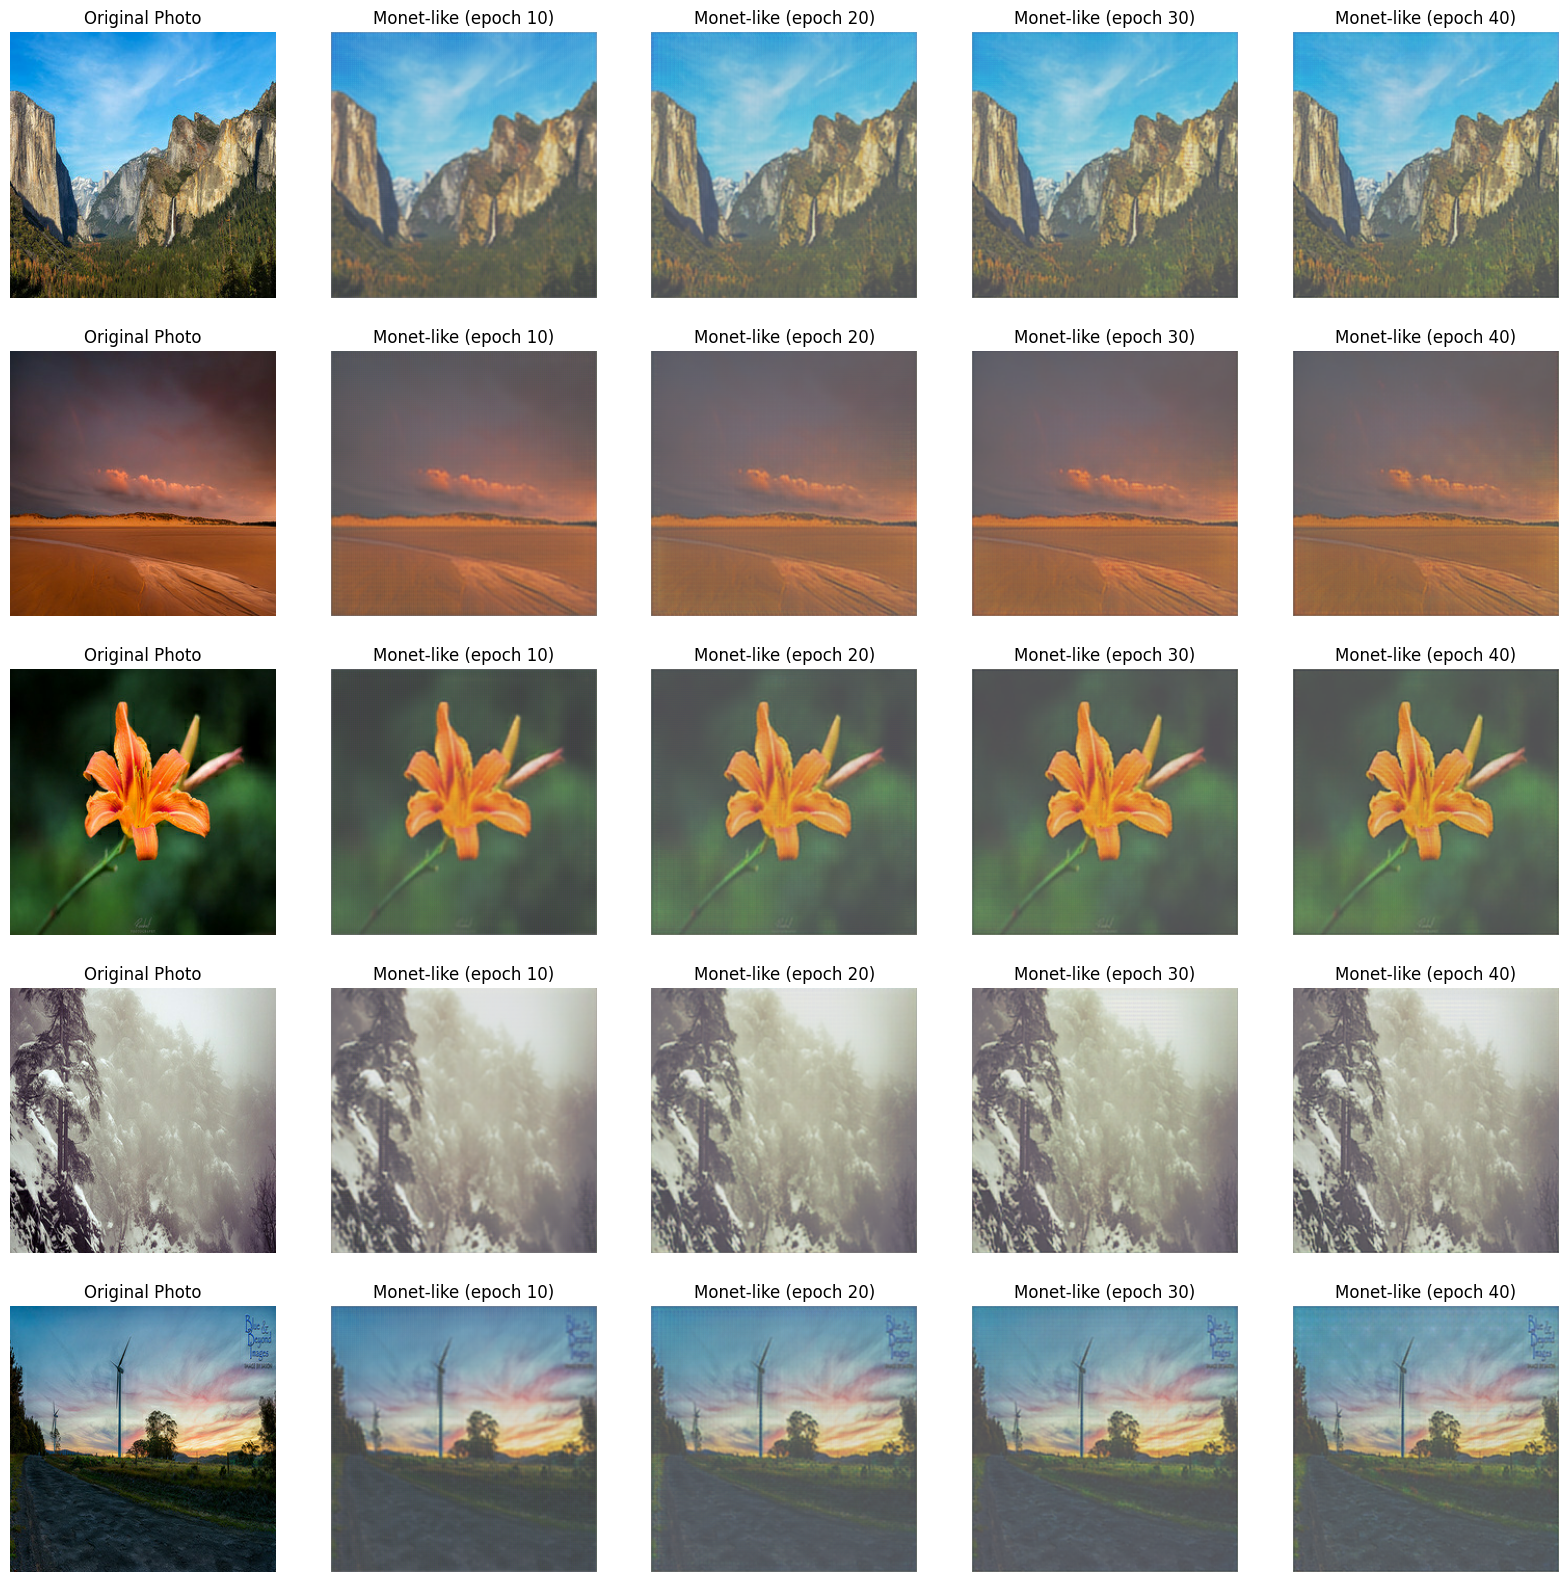

In [29]:
fix, ax = plt.subplots(5, 5, figsize=(20,20))

photos = []
for i, photo in enumerate(photo_originals.take(5)):
    photos.append(photo)
    photo = (photo[0]*127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(photo)
    ax[i, 0].set_title('Original Photo')
    ax[i, 0].axis('off')

for ckpt in [10, 20, 30, 40]:
    cycle_gan_model.load_weights(f'checkpoints/cp-00{ckpt}.ckpt')
    for i, photo in enumerate(photos):
        monet_like = cycle_gan_model.m_gen(photo, training= False)[0].numpy()   
        monet_like = (monet_like*127.5 + 127.5).astype(np.uint8)
        col = ckpt//10
        ax[i, col].imshow(monet_like)
        ax[i, col].set_title(f'Monet-like (epoch {ckpt})')
        ax[i, col].axis('off')


# GENERATE & ZIP MONETS FOR KAGGLE
Lastly, I use the trained CycleGAN Monet generator to transfer styling to the 7028 original photos. Following the competition recommendation, I avoid saving individual image files, which could exceed the Kaggle limits on output file number. Instead, the Monet-like images are saved into a zip file as they are produced. 

Thanks for reading my notebook and offerring any comments or suggestions!

In [30]:
import os
import zipfile
import PIL
from PIL import Image
import io

zip_filename = '/kaggle/working/images.zip'

with zipfile.ZipFile(zip_filename, 'a') as myzip:
    i = 1
    for batch in photo_originals:
        for image in (batch):
            
            fake_monet = cycle_gan_model.m_gen(tf.expand_dims(image, 0), training=False)[0].numpy()
            fake_monet = (fake_monet * 127.5 + 127.5).astype(np.uint8)
            
            fake_monet = PIL.Image.fromarray(fake_monet)
            
            img_byte_arr = io.BytesIO()
            fake_monet.save(img_byte_arr, format='JPEG', quality=95)
            img_byte_arr = img_byte_arr.getvalue()
            
            fake_monet_filename = str(i) +'.jpg'
            myzip.writestr(fake_monet_filename, img_byte_arr)
            
            i += 1